In [1]:
# mlflow ui --port 6010 --backend-store-uri file:/share/lazy/will/ConstrastiveLoss/Logs
# watch -n 0.5 nvidia-smi

In [13]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, utils

from VQVAE import VQVAE
from train import train
from utilities import start_mlflow_experiment, Params, save_to_mlflow, count_parameters
from utilities import load_full_state, select_gpu, LMDBDataset
import matplotlib.pyplot as plt
import numpy as np
from seaborn import heatmap

from tqdm import tqdm
import mlflow

# questionable
from collections import namedtuple
import lmdb


In [2]:
import lmdb

lmdb_env = lmdb.open('/data/home/will/Lane-finder-mini/VQVAE/latent samples/')
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()

keys = []
values = []
for key, value in lmdb_cursor:
    keys.append(key)
    values.append(value)

In [5]:
CodeRow = namedtuple('CodeRow', ['top', 'bottom', 'filename'])
code_dataset = LMDBDataset('/data/home/will/Lane-finder-mini/VQVAE/latent samples/')
iterable_dataset = iter(code_dataset)

In [6]:
small_sample, large_sample, _ = next(iterable_dataset)

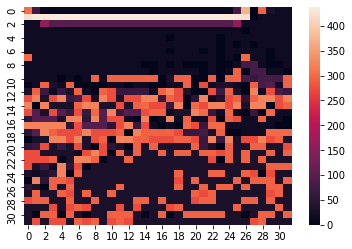

In [17]:
heatmap(small_sample)

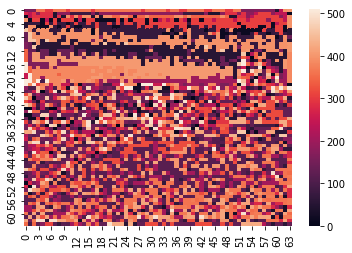

In [18]:
heatmap(large_sample)

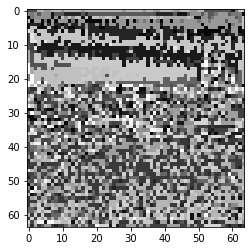

In [9]:
sample = 255*large_sample.float()//large_sample.max()
sample = sample.int().numpy()
img = np.dstack((sample, sample, sample))
plt.imshow(img)
plt.show()

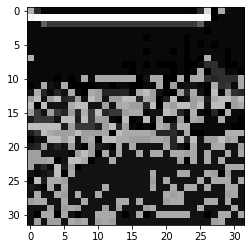

In [10]:
sample = 255*small_sample.float()//small_sample.max()
sample = sample.int().numpy()
img = np.dstack((sample, sample, sample))
plt.imshow(img)
plt.show()

In [5]:
CodeRow = namedtuple('CodeRow', ['top', 'bottom', 'filename'])

def extract(lmdb_env, loader, model, device):
    index = 0

    with lmdb_env.begin(write=True) as txn:
        pbar = tqdm(loader)

        for img, _ in pbar:
            filename = 'sample?'
            img = img.to(device)

            _, _, _, id_t, id_b = model.encode(img)
            id_t = id_t.detach().cpu().numpy()
            id_b = id_b.detach().cpu().numpy()

            for file, top, bottom in zip(filename, id_t, id_b):
                row = CodeRow(top=top, bottom=bottom, filename=file)
                txn.put(str(index).encode('utf-8'), pickle.dumps(row))
                index += 1
                pbar.set_description(f'inserted: {index}')

        txn.put('length'.encode('utf-8'), str(index).encode('utf-8'))

In [38]:
device = select_gpu(1)
args = Params(32, 10, 4e-4, 256, device)

transform = transforms.Compose(
    [
        transforms.Resize(args.size),
        transforms.CenterCrop(args.size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

dataset = datasets.ImageFolder('/share/lazy/will/ConstrastiveLoss/Imgs/color_images/test/', transform=transform)
loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, pin_memory = True)
model = VQVAE(channel=128)
optimizer = optim.Adam(model.parameters(), lr=args.lr)

load_full_state(model, optimizer, '/share/lazy/will/ConstrastiveLoss/Logs/0/64a43ca191944cba89536145c4422027/artifacts/run_stats.pyt')
model = model.to(args.device)
model.eval()

map_size = 100 * 1024 * 1024 * 1024

env = lmdb.open('latent samples', map_size=map_size)

extract(env, loader, model, args.device)

  0%|          | 0/655 [00:00<?, ?it/s]

we also froze 0 weights
Of the 79.0 parameter layers to update in the current model, 79.0 were loaded


inserted: 4579: 100%|██████████| 655/655 [17:17<00:00,  1.58s/it]
